In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df_tran = pd.read_csv('../dataset/tran.txt',names=['primary-date','time','approximate-indicator','secondary-date','approximate-indicator',
  'transaction-ID','player','type','from-team','from-league','to-team','to-league','draft-type','draft-round','pick-number','info'])
df_playerid = pd.read_csv('../dataset/playerid_list.csv',names=['LASTNAME','FIRSTNAME','PLAYERID','DAVENPORTCODE','MLBCODE','player'],skiprows=1);
df_master = pd.read_csv('../dataset/Master.csv')
df_batstat = pd.read_csv('../dataset/war_daily_bat.txt')
df_pitchstat = pd.read_csv('../dataset/war_daily_pitch.txt')
df_cpi = pd.read_csv('../dataset/CPI.csv')
pd.set_option('display.max_columns', 60)

# Data Cleanup
# Recontructing invalid dates
df_tran['primary-date'] = df_tran['primary-date'].astype('str')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})[0]{4}', r'\g<1>0101')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})(..)[0]{2}', r'\g<1>\g<2>01')

#Extracting only trades from transaction dataframe
df_tran = df_tran[df_tran['type'] == "T "]
df_tran = df_tran[df_tran['to-league'].isin(['AL','NL'])]
df_tran = df_tran[df_tran['from-league'].isin(['AL','NL'])]

df_tran['primary-date'] = pd.to_datetime(df_tran['primary-date'], format='%Y%m%d')
df_tran['tranYear'] = df_tran['primary-date'].apply(lambda x : int(x.year))

dcash = df_tran['info'].str.replace(r' million', '000000') #replace million
dcash = dcash.str.replace(r'\D*\d*(\$\d*)\D*\d*', '\g<1>') #strip anything but $ followed by some digits
dcash = dcash.str.replace(r'\$$', '$0') #replace unknown cash as 0
df_tran['cash'] = dcash.str.replace(r'^((?!\$\d*).)*$', '') #replace anything that doen't contain a dollar with empty string

/home/piyush/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
df_tran['transaction-ID'].nunique()

5622

In [3]:
import networkx as nx
import operator
G =nx.Graph()
for index, row in df_tran.iterrows():
    G.add_edge(row['from-team'] ,row['to-team']) 

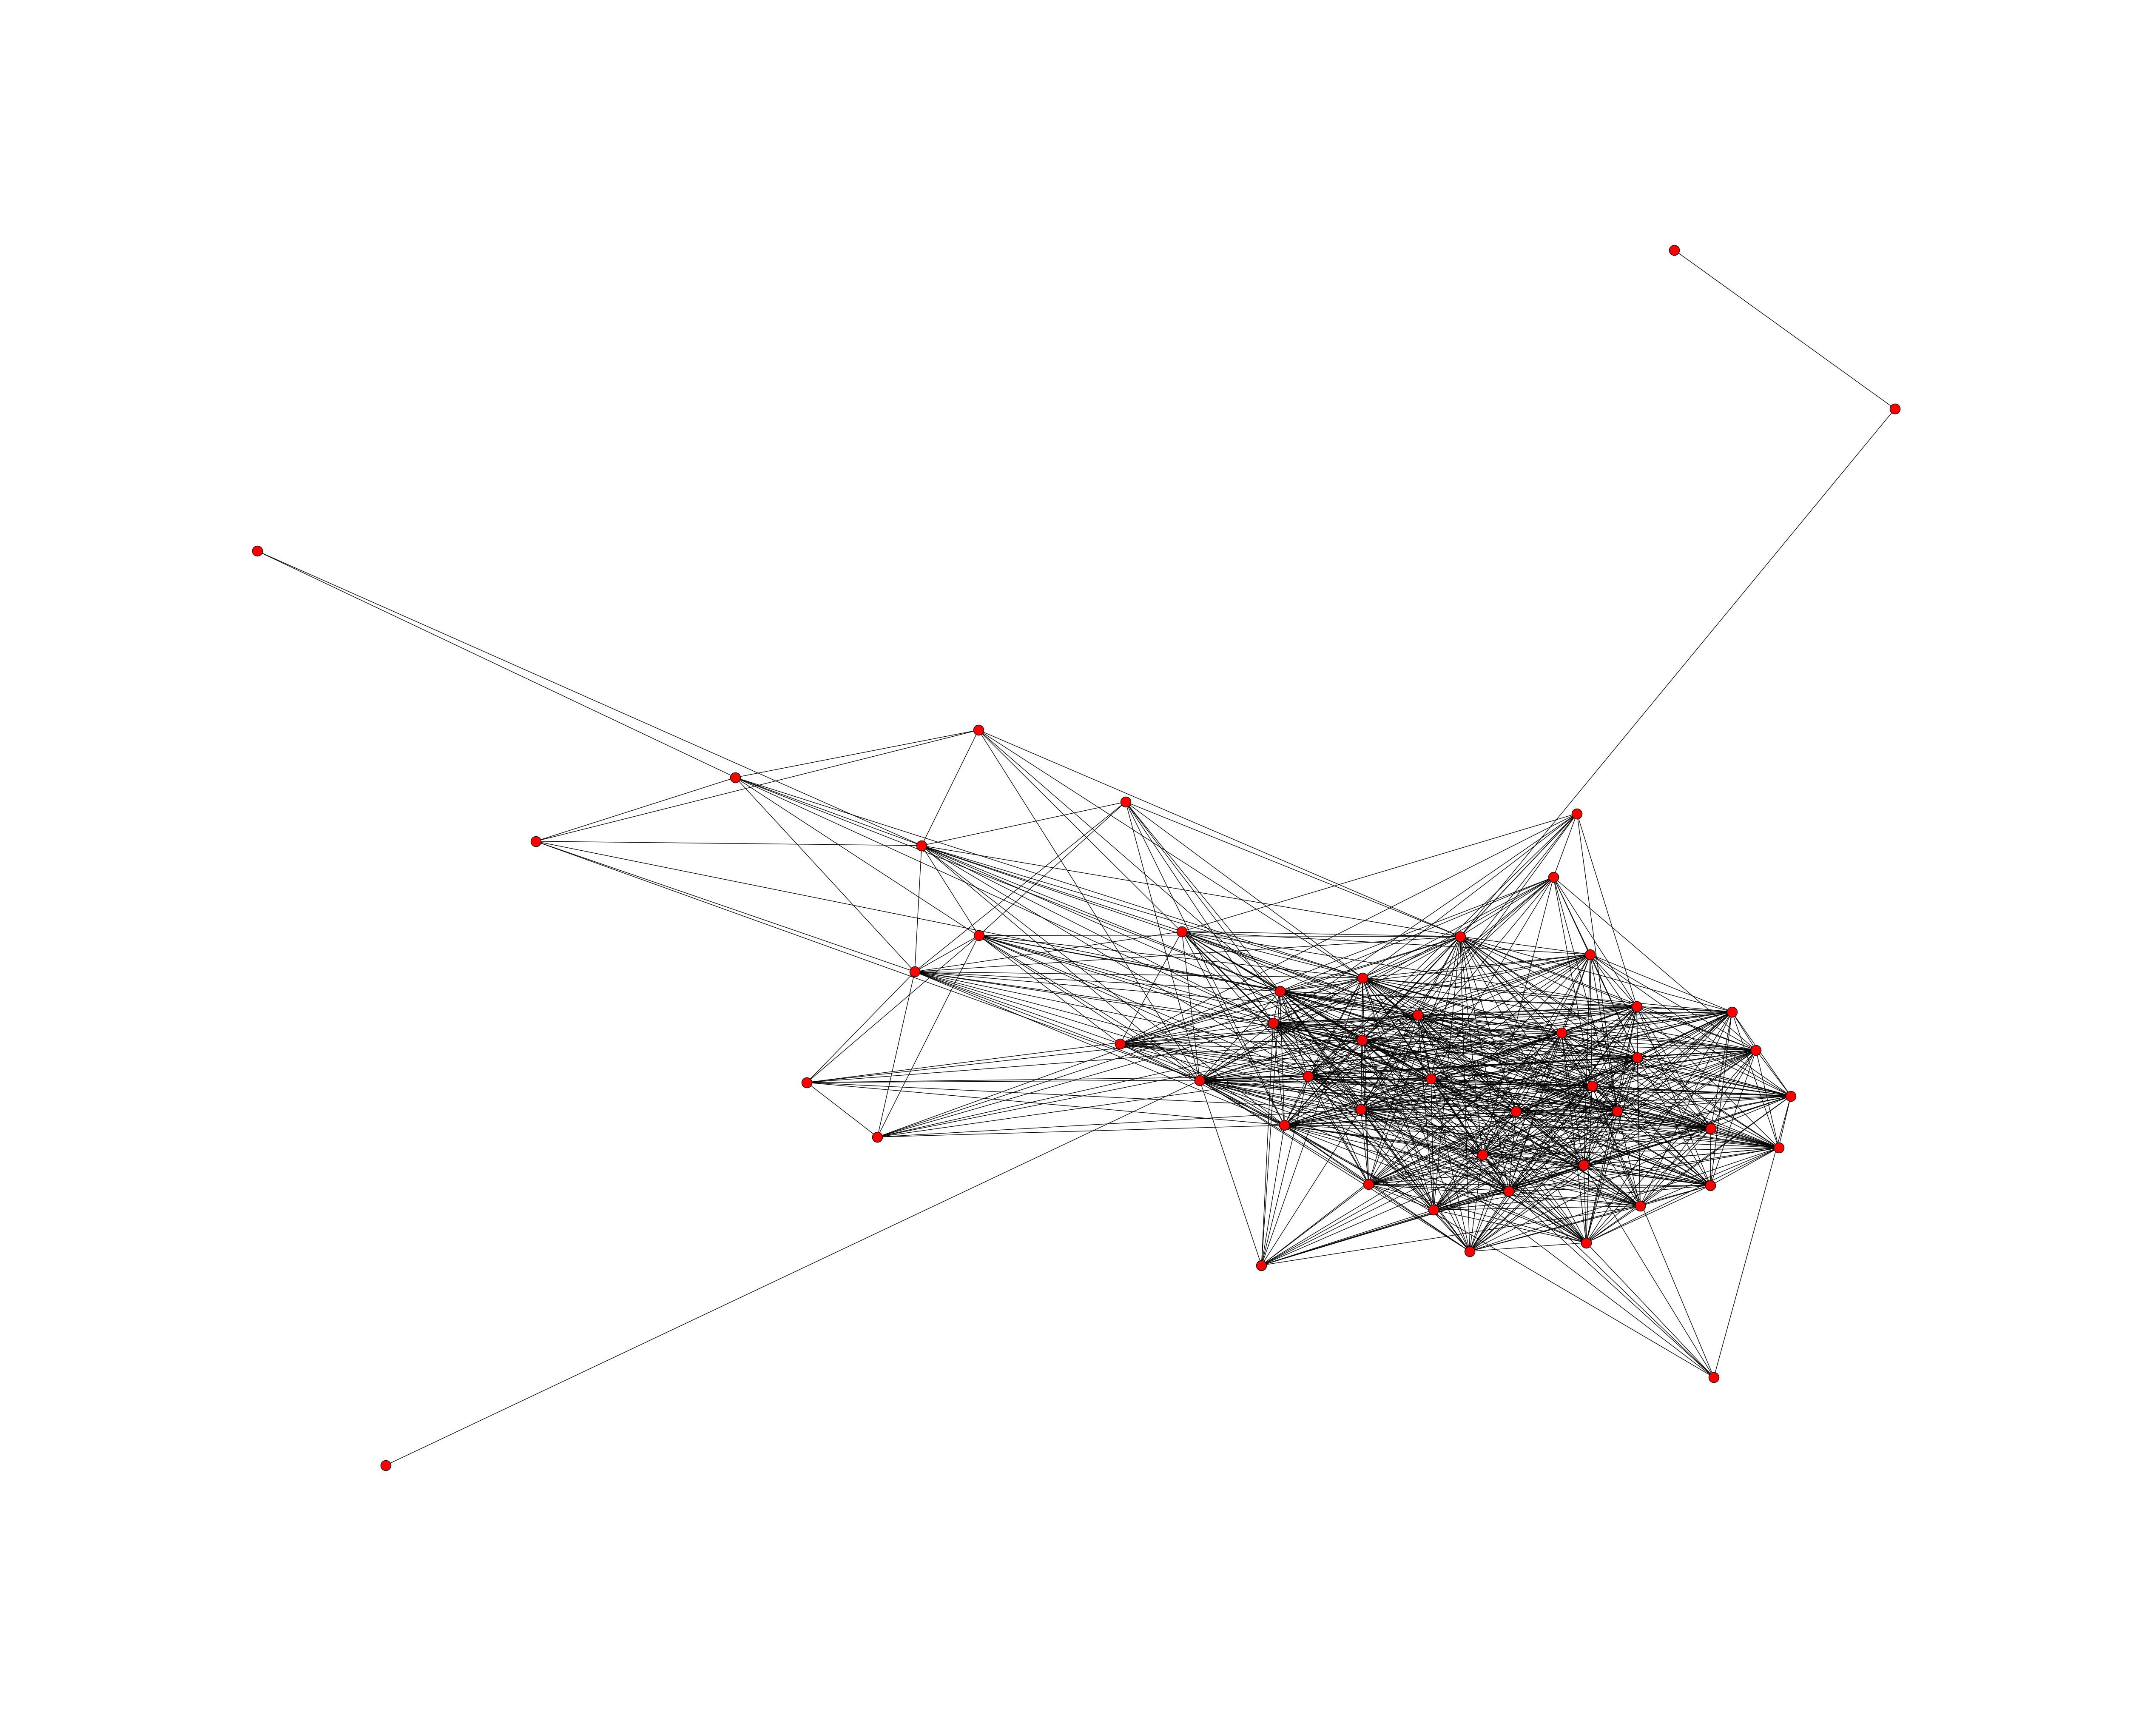

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
fig = plt.figure (figsize=(50,40))
nx.draw(G,pos=nx.spring_layout(G))
plt.savefig('graph.png')

In [5]:
df_tran_ANL = df_tran[(df_tran['to-league'] == 'AL') & (df_tran['from-league'] == 'AL')]
df_tran_ANL['transaction-ID'].nunique()

1518

In [6]:
df_tran_ANL = df_tran[(df_tran['to-league'] == 'NL') & (df_tran['from-league'] == 'NL')]
df_tran_ANL['transaction-ID'].nunique()

1789

In [7]:
df_tran_ANL = df_tran[(df_tran['to-league'] == 'AL') & (df_tran['from-league'] == 'NL')]
df_tran_ANL['transaction-ID'].nunique()

2346

In [8]:
df_tran_ANL = df_tran[(df_tran['to-league'] == 'NL') & (df_tran['from-league'] == 'AL')]
df_tran_ANL['transaction-ID'].nunique()

2348

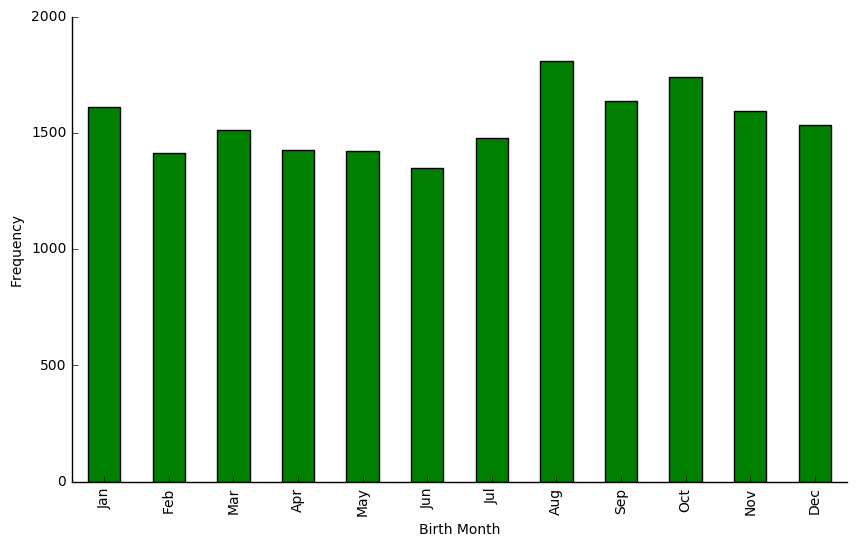

In [9]:
# Birthday Skew
fig = plt.figure(figsize=(10, 6))
 
ax = plt.subplot(111) 

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()   
numBins = 50
x = df_master['birthMonth']
x = x.dropna()

plt.xlabel("Birth Month")
plt.ylabel("Frequency")

order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']
x = x.apply(lambda x : order[int(x)-1])

# Draw the bar chart
x.value_counts().ix[order].plot(ax=ax, kind='bar',color='green')
plt.savefig('birth.png')
plt.show()

In [10]:
# month where most transactions take place

df_ttime = df_tran['primary-date']
df_ttime = df_ttime.dropna()
df_ttime= df_ttime.apply(lambda x : x.strftime('%b'))

fig = plt.figure(figsize=(10, 6))
 
ax = plt.subplot(111) 

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()   

plt.xlabel("Month")
plt.ylabel("Frequency")



order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']

# Draw the bar chart
df_ttime.value_counts().ix[order].plot(ax=ax, kind='bar',color='#3F5D7D')
#ax.hist(df_ttime,numBins,color='green')
plt.savefig('trans.png')
plt.show()

ValueError: year=1886 is before 1900; the datetime strftime() methods require year >= 1900

In [11]:
# age at which player gets traded
df_master_year = df_master[['birthYear','retroID']]
df_master_year=  df_master_year.rename(columns = {'retroID':'player'})
df_master_year = df_master_year.dropna()
df_merged = pd.merge(df_tran,df_master_year,on='player',how='inner')
df_merged['Difference'] = df_merged['tranYear'].sub(df_merged['birthYear'], axis=0)

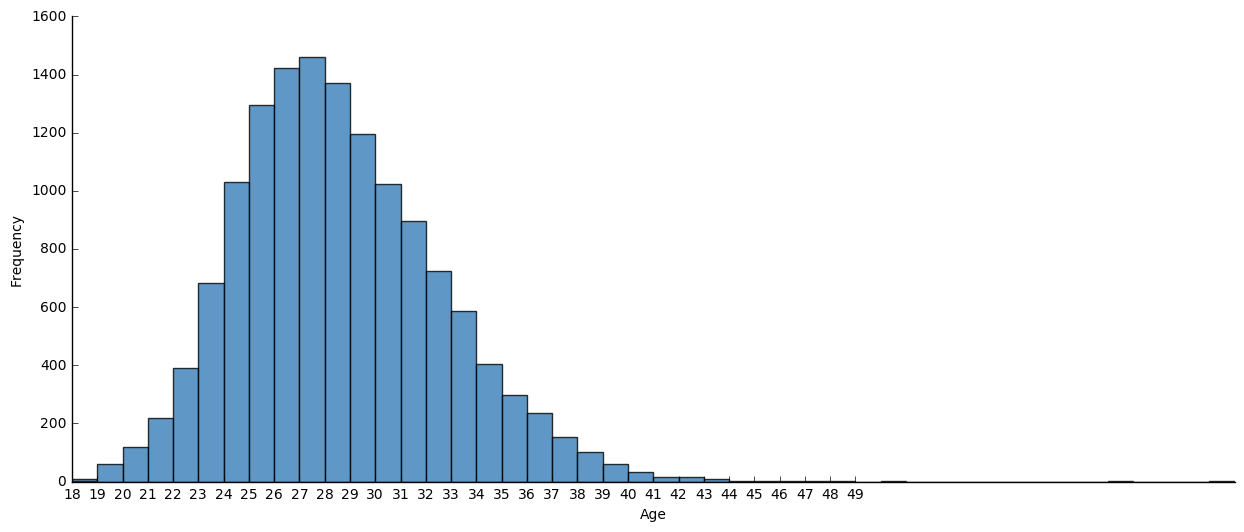

In [12]:
fig = plt.figure(figsize=(15, 6))
 
ax = plt.subplot(111) 

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()   

x = df_merged['Difference']
x = x.dropna()
numBins = int(max(x) - min(x))
x = x.apply(lambda x : int(x))
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.xticks(range(0,50))
ax.hist(x,numBins,color='#377eb8',alpha=0.8)
plt.savefig('age.png')
plt.show()

In [13]:
# effect of experience on trade veterens vs prospects
df_master_dyear = df_master[['debut','retroID']]
df_master_dyear=df_master_dyear.rename(columns = {'retroID':'player'})
df_master_dyear = df_master_dyear.dropna()
df_master_dyear['debut'] = pd.to_datetime(df_master_dyear['debut'], format='%Y-%m-%d',errors = 'coerce')
df_master_dyear['debut'] = df_master_dyear['debut'].apply(lambda x : x.year)
df_merged = pd.merge(df_tran,df_master_dyear,on='player',how='inner')
df_merged['Difference'] = df_merged['tranYear'].sub(df_merged['debut'], axis=0)

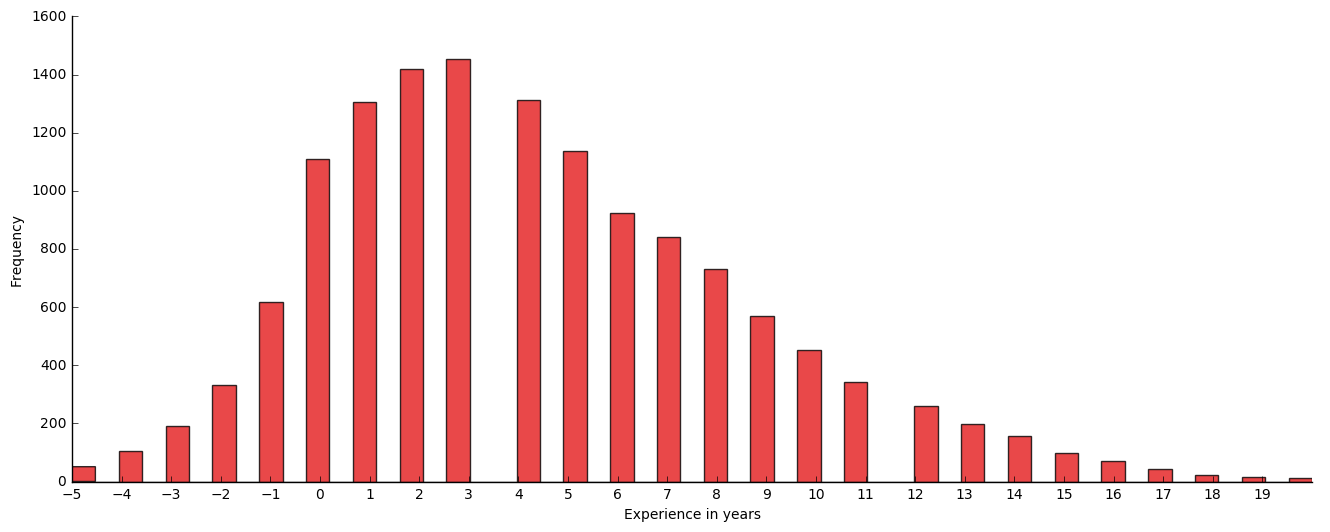

In [14]:
fig = plt.figure(figsize=(16, 6))
 
ax = plt.subplot(111) 

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()   

x = df_merged['Difference']
x = x.dropna()
numBins = int(max(x) - min(x))
x = x.apply(lambda x : int(x))
plt.xlabel("Experience in years")
plt.ylabel("Frequency")
plt.xticks(range(-7,28))
ax.hist(x,numBins,color='#e41a1c',alpha=0.8, range=[-5, 20])
plt.savefig('exp.png')
plt.show()

Baseline Model

In [15]:
df_master['player_ID'] = df_master['bbrefID']
df_batstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')
df_pitchstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')

In [16]:
df_batstat.head()

name_common   age    mlb_ID  player_ID  year_ID team_ID  stint_ID lg_ID  \
0  David Aardsma  22.0  430911.0  aardsda01     2004     SFG         1    NL   
1  David Aardsma  24.0  430911.0  aardsda01     2006     CHC         1    NL   
2  David Aardsma  25.0  430911.0  aardsda01     2007     CHW         1    AL   
3  David Aardsma  26.0  430911.0  aardsda01     2008     BOS         1    AL   
4  David Aardsma  27.0  430911.0  aardsda01     2009     SEA         1    AL   

   PA   G   Inn  runs_bat  runs_br  runs_dp  runs_field  runs_infield  \
0   0  11  10.7      0.00      0.0      0.0         0.0           0.0   
1   3  45  53.0     -0.90      0.0      0.0         0.0           0.0   
2   0  25  32.3      0.00      0.0      0.0         0.0           0.0   
3   1  47  48.7     -0.29      0.0      0.0         0.0           0.0   
4   0  73  71.3      0.00      0.0      0.0         0.0           0.0   

   runs_outfield  runs_catcher  runs_good_plays  runs_defense  runs_position  \
0            0.0           0.0              0.0           0.0           0.05   
1            0.0           0.0              0.0           0.0           0.21   
2            0.0           0.0              0.0           0.0           0.11   
3            0.0           0.0              0.0           0.0           0.22   
4            0.0           0.0              0.0           0.0           0.32   

   runs_position_p  runs_replacement  runs_above_rep  runs_above_avg  \
0             0.00               0.0             0.1             0.1   
1             0.46               0.0            -0.2            -0.2   
2             0.00               0.0             0.1             0.1   
3             0.14               0.0             0.1             0.1   
4             0.00               0.0             0.3             0.3   

   runs_above_avg_off  runs_above_avg_def   WAA  WAA_off  WAA_def   WAR  \
0                 0.1                 0.1  0.01     0.01     0.00  0.01   
1                -0.2                 0.2 -0.02    -0.02     0.00 -0.02   
2                 0.1                 0.1  0.01     0.01     0.02  0.01   
3                 0.1                 0.2  0.00     0.00     0.05  0.00   
4                 0.3                 0.3  0.03     0.03     0.06  0.03   

   WAR_def  WAR_off  WAR_rep    salary pitcher  teamRpG   oppRpG  oppRpPA_rep  \
0     0.00     0.01      0.0  300000.0       Y  4.67546  4.67092      0.08651   
1     0.00    -0.02      0.0       NaN       Y  4.86164  4.86675      0.09085   
2     0.02     0.01      0.0  387500.0       Y  4.86335  4.85895      0.08422   
3     0.05     0.00      0.0  403250.0       Y  4.70549  4.70400      0.08092   
4     0.06     0.03      0.0  419000.0       Y  4.80227  4.79788      0.08302   

   oppRpG_rep  pyth_exponent  pyth_exponent_rep  waa_win_perc  \
0     4.67092          1.891              1.890        0.5005   
1     4.86467          1.912              1.913        0.4995   
2     4.85895          1.912              1.912        0.5004   
3     4.70321          1.894              1.894        0.5001   
4     4.79788          1.905              1.905        0.5004   

   waa_win_perc_off  waa_win_perc_def  waa_win_perc_rep  OPS_plus  TOB_lg  \
0            0.5005            0.5005            0.5000       NaN   0.000   
1            0.4995            0.5005            0.4998    -100.0   0.694   
2            0.5004            0.5004            0.5000       NaN   0.000   
3            0.5001            0.5005            0.4999    -100.0   0.345   
4            0.5004            0.5004            0.5000       NaN   0.000   

   TB_lg   retroID  
0  0.000  aardd001  
1  0.896  aardd001  
2  0.000  aardd001  
3  0.434  aardd001  
4  0.000  aardd001

In [17]:
df_batstat_sort = df_batstat.sort('age')
df_batstat_sort = df_batstat_sort[pd.notnull(df_batstat_sort['age'])]
agedict = {}

#print df_batstat_sort.age
for index, row in df_batstat_sort.iterrows():
    if(row['age'] in agedict):
        agedict[row['age']].append(row['WAR'])
    else:
        agedict[row['age']] = [row['WAR']]

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [18]:
age = []
avg_WAR= []
i=0
for key in agedict:
    if (~np.isnan(key)):
        avg = np.nansum(agedict[key]) / float(len(agedict[key]))
        age.append(key)
        avg_WAR.append(avg)
        
age_df = pd.DataFrame({ 'Age' : age,'Average_WAR' : avg_WAR}).sort('Age')

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [19]:
#age_df
def getAvgWarForAge(age):
    return (age_df[(age_df['Age'] == age)]['Average_WAR']).iloc[0]

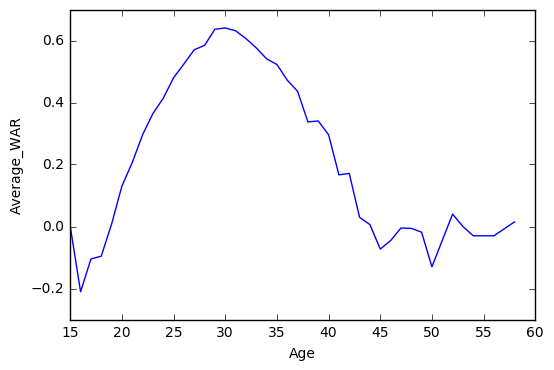

In [20]:
plt.xlabel("Age")
plt.ylabel("Average_WAR")
plt.plot(age_df.Age, age_df.Average_WAR);

In [21]:
#Calculates the absolute difference between two sides of a trade by summing the WAR values of each player on each side for 
#the year in which the trade took place
def trade_value_old(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        val = 0
        for index, row in td.iterrows():
            #val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction 
                    continue
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(df_batstat['year_ID'] == row['tranYear'])]
                if not player_df_year.empty:
                    val += float(player_df_year[metric].iloc[0])
                elif not player_df.empty:
                    # take a random value if we don't have war for that transaction year, put logic to change this to nearest year
                    val += float(player_df['WAR'].iloc[0])
                else:
                    ## figure out a way to find war for these players
                    val += 0
        player_vals.append(val)
    return ((player_vals[0]-player_vals[1]),tranID)

In [22]:
#Calculates the absolute difference between two sides of a trade by summing the WAR values of each player on each side one
# year after the trade took place
def trade_value(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        val = 0
        for index, row in td.iterrows():
            #val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction
                    continue
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(df_batstat['year_ID'] == row['tranYear'])]
                #instead need a df for the player after the trans year, and not just next, but all consecutive years
                for i in range(15):
                    player_df_year_next = player_df[(df_batstat['year_ID'] == (row['tranYear'] + i))]
                    if not player_df_year_next.empty:
                        # get the value of metric for each year after trade until 15 years else assume 0
                        val += float(player_df_year_next[metric].iloc[0]) - getAvgWarForAge(player_df_year_next['age'].iloc[0])
                    else:
                        ## figure out a way to find war for these players
                        val += 0
        player_vals.append(val)
    return ((player_vals[0]-player_vals[1]),tranID)

In [23]:
#Calculates the absolute difference between two sides of a trade by summing the WAR values of each player on each side one
# year after the trade took place
def trade_value_next(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        val = 0
        for index, row in td.iterrows():
            #val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction 
                    continue
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(df_batstat['year_ID'] == row['tranYear'])]
                player_df_year_next = player_df[(df_batstat['year_ID'] == (row['tranYear'] + 1))]
                if not player_df_year_next.empty:
                    # get the value of metric one year after trade
                    val += float(player_df_year_next[metric].iloc[0])
                elif not player_df_year.empty:
                    # if can't find above value assume its the same as the last year's value 
                    val += float(player_df_year[metric].iloc[0])
                elif not player_df.empty:
                    # take a random value if we don't have war for that transaction year, put logic to change this to nearest year
                    val += float(player_df[metric].iloc[0])
                else:
                    ## figure out a way to find war for these players
                    val += 0
        player_vals.append(val)
    return (abs(player_vals[1]-player_vals[0]),tranID)

In [24]:
#Calculating the trade value difference for each transaction using metric WAR,WAA,PA,Salary & TA
trade_val_list_WAR = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    trade_val_list_WAR.append(trade_value(x,'WAR'))

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<function matplotlib.pyplot.show>

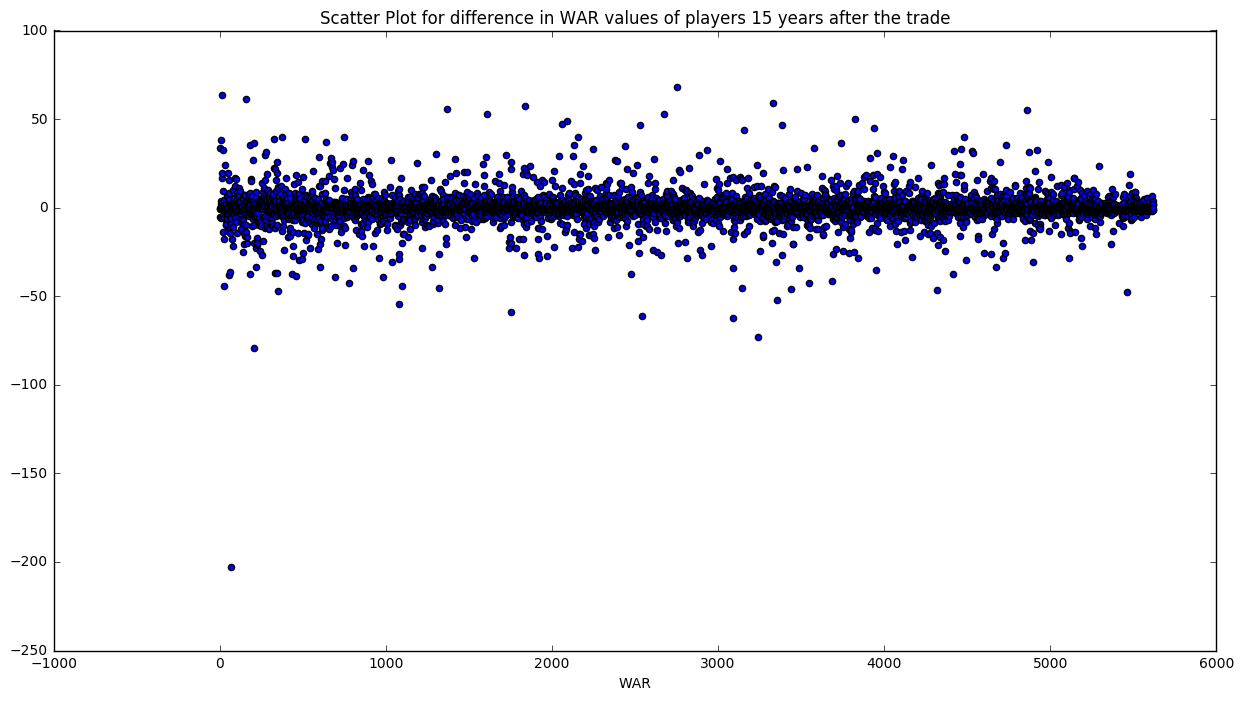

In [25]:
#trade_val_list
new_trade_val_list_WAR =[]
for i in trade_val_list_WAR:
    new_trade_val_list_WAR.append(i[0])

# Scatter plot for Wins Above Replacement
x_pos = np.arange(0,len(new_trade_val_list_WAR))
plt.figure(figsize=(15, 8))
plt.title("Scatter Plot for difference in WAR values of players 15 years after the trade")
plt.xlabel("WAR")
plt.scatter(x_pos, new_trade_val_list_WAR)
plt.show

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<function matplotlib.pyplot.show>

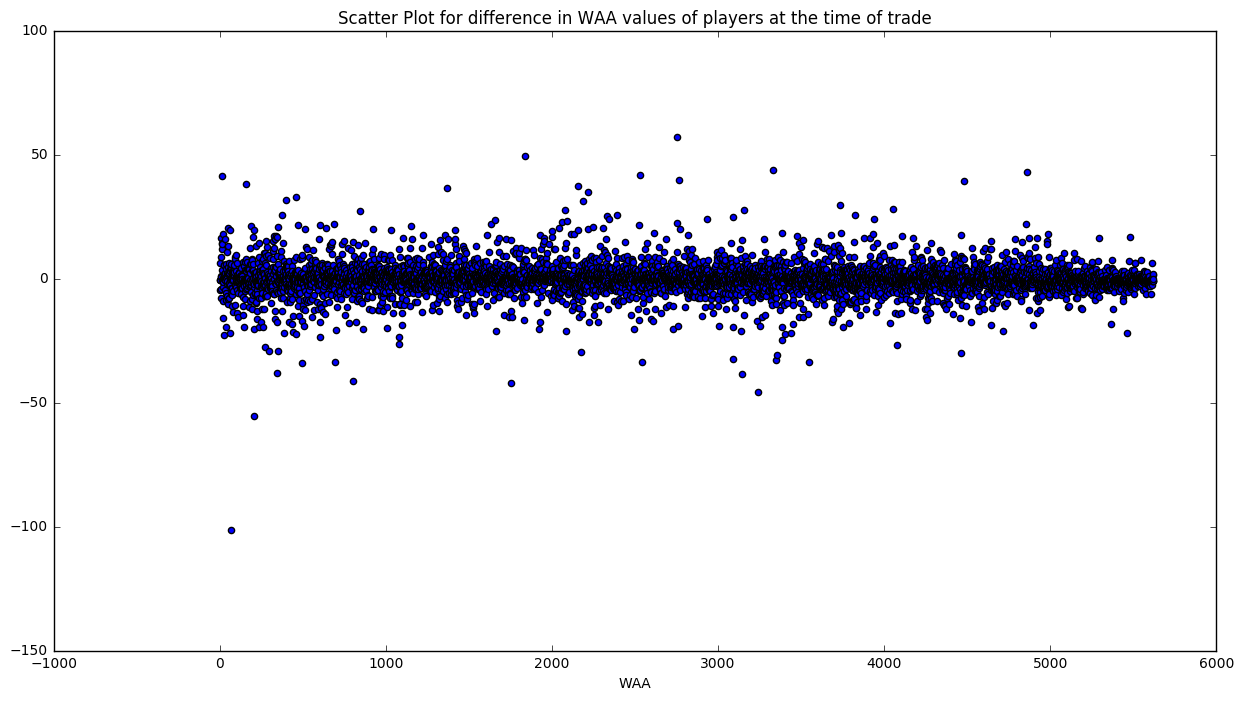

In [26]:
# Scatter plot for Wins Above Average
trade_val_list_WAA = []
for x in transactions:
    trade_val_list_WAA.append(trade_value(x,'WAA'))
    
#trade_val_list
new_trade_val_list_WAA =[]
for i in trade_val_list_WAA:
    new_trade_val_list_WAA.append(i[0])
    
x_pos = np.arange(0,len(new_trade_val_list_WAA))
plt.figure(figsize=(15, 8))
plt.title("Scatter Plot for difference in WAA values of players at the time of trade")
plt.xlabel("WAA")
plt.scatter(x_pos, new_trade_val_list_WAA)
plt.show

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<function matplotlib.pyplot.show>

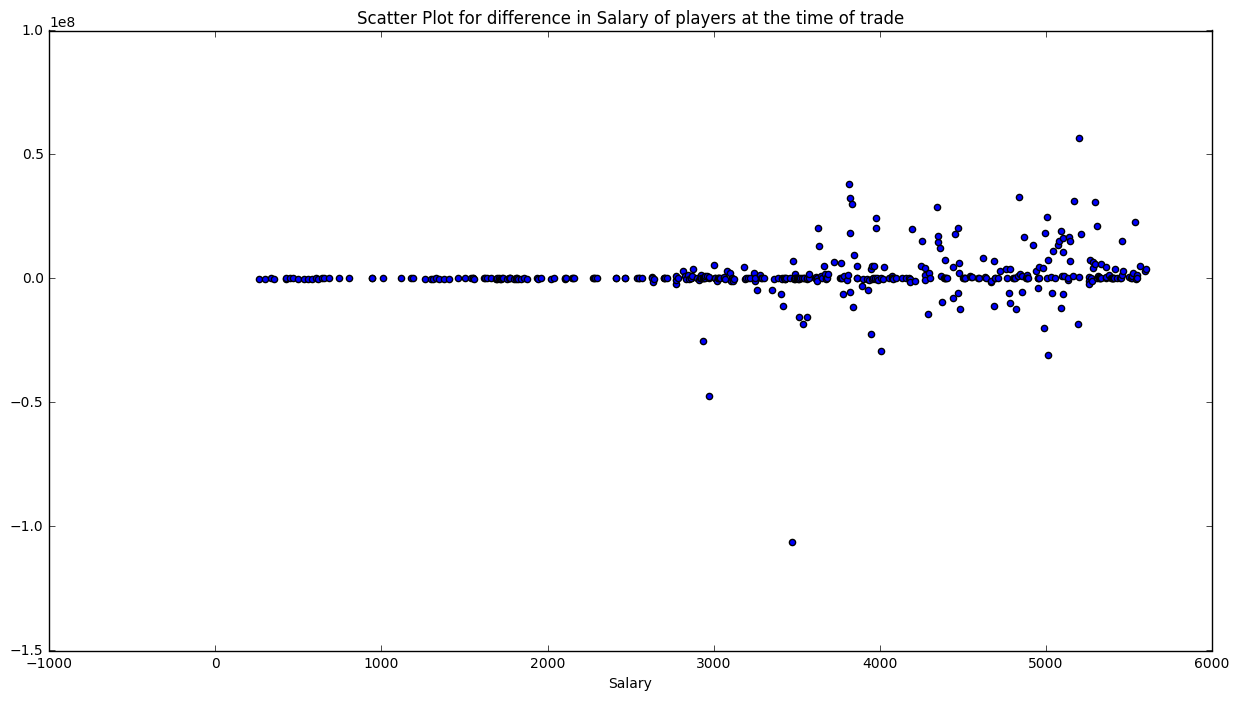

In [27]:
# Scatter plot for salary
trade_val_list_Salary = []
for x in transactions:
    trade_val_list_Salary.append(trade_value(x,'salary'))
    
#trade_val_list
new_trade_val_list_Salary =[]
for i in trade_val_list_Salary:
    new_trade_val_list_Salary.append(i[0])
    
x_pos = np.arange(0,len(new_trade_val_list_Salary))
plt.figure(figsize=(15, 8))
plt.title("Scatter Plot for difference in Salary of players at the time of trade")
plt.xlabel("Salary")
plt.scatter(x_pos, new_trade_val_list_Salary)
plt.show

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<function matplotlib.pyplot.show>

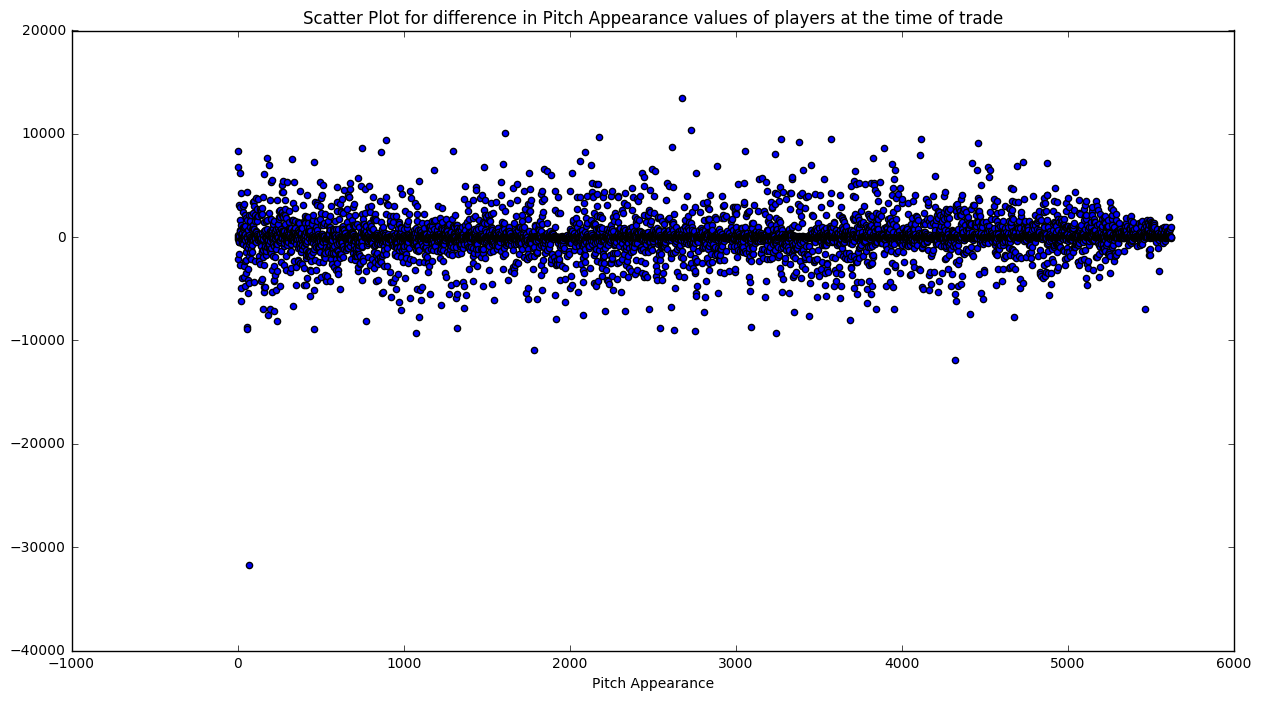

In [28]:
# Scatter plot for pitch appearances
trade_val_list_PA = []
for x in transactions:
    trade_val_list_PA.append(trade_value(x,'PA'))
    
#trade_val_list
new_trade_val_list_PA =[]
for i in trade_val_list_PA:
    new_trade_val_list_PA.append(i[0])
    
x_pos = np.arange(0,len(new_trade_val_list_PA))
plt.figure(figsize=(15, 8))
plt.title("Scatter Plot for difference in Pitch Appearance values of players at the time of trade")
plt.xlabel("Pitch Appearance")
plt.scatter(x_pos, new_trade_val_list_PA)
plt.show

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<function matplotlib.pyplot.show>

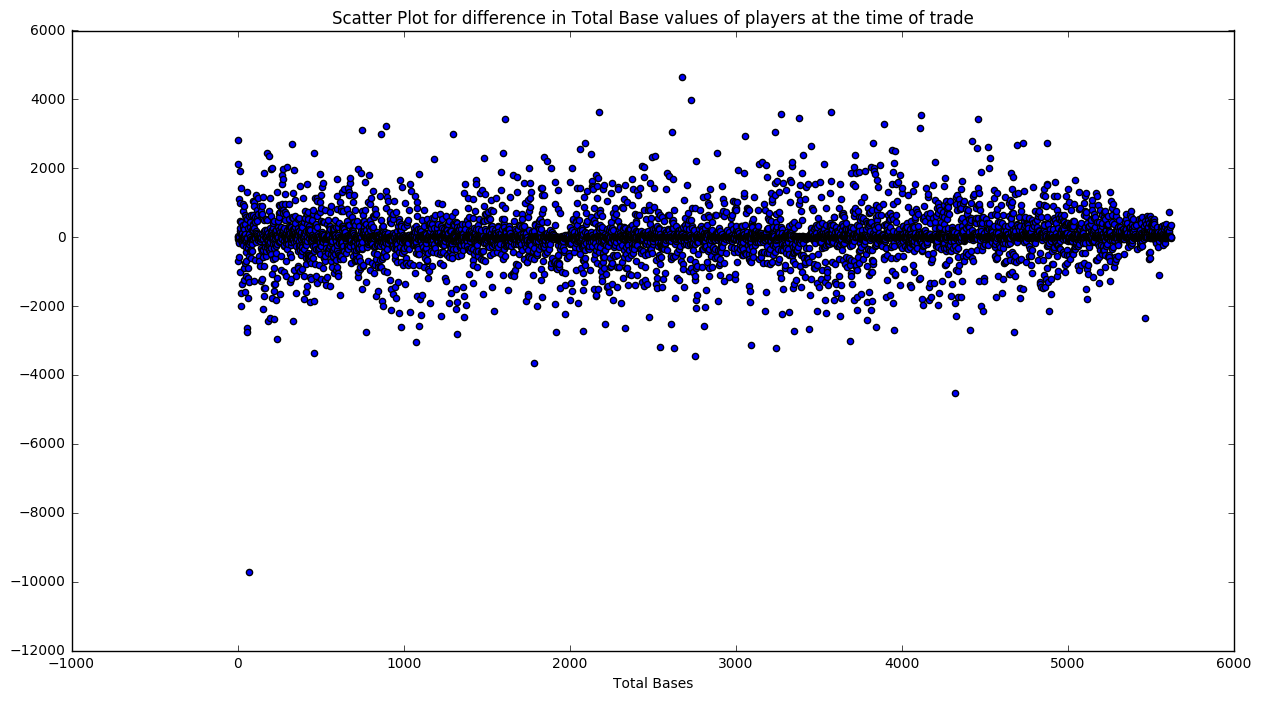

In [29]:
# Scatter plot for total bases
trade_val_list_TB_lg = []
for x in transactions:
    trade_val_list_TB_lg.append(trade_value(x,'TB_lg'))
    
#trade_val_list
new_trade_val_list_TB_lg =[]
for i in trade_val_list_TB_lg:
    new_trade_val_list_TB_lg.append(i[0])
    
x_pos = np.arange(0,len(new_trade_val_list_TB_lg))
plt.figure(figsize=(15, 8))
plt.title("Scatter Plot for difference in Total Base values of players at the time of trade")
plt.xlabel("Total Bases")
plt.scatter(x_pos, new_trade_val_list_TB_lg)
plt.show

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<function matplotlib.pyplot.show>

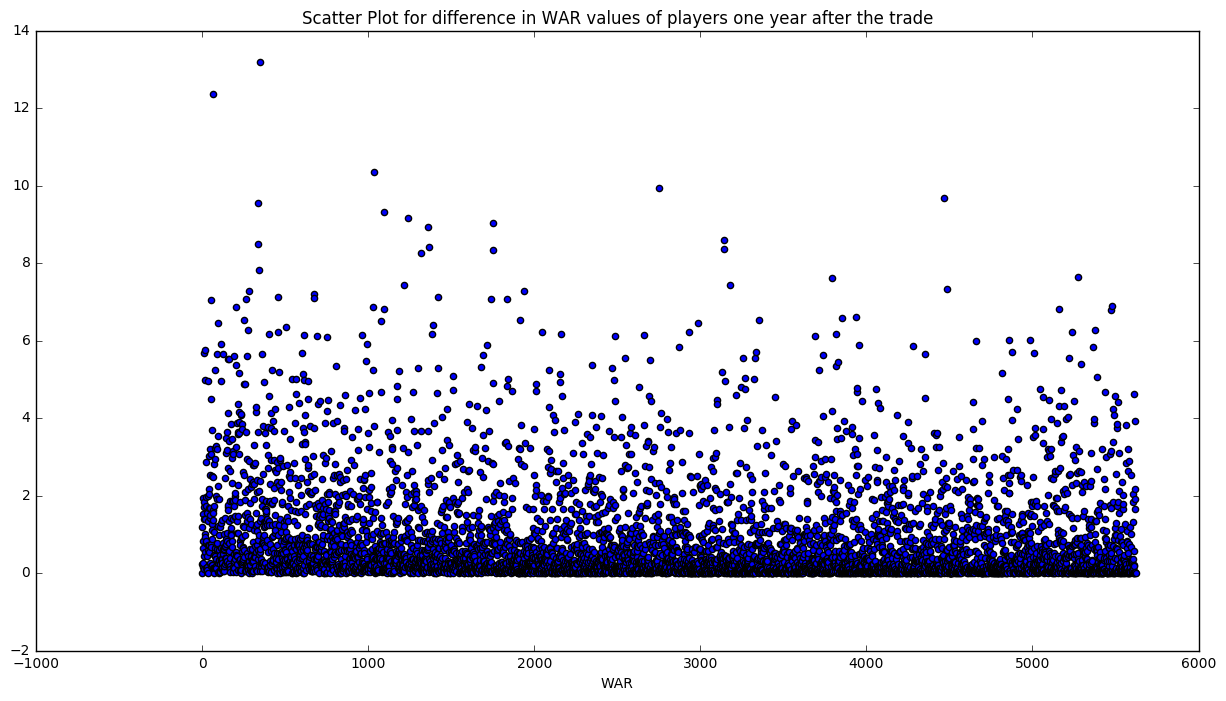

In [30]:
trade_val_list_WAR_next = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    trade_val_list_WAR_next.append(trade_value_next(x,'WAR'))
    
#trade_val_list
new_trade_val_list_WAR_next =[]
for i in trade_val_list_WAR_next:
    new_trade_val_list_WAR_next.append(i[0])
    
x_pos = np.arange(0,len(new_trade_val_list_WAR_next))
plt.figure(figsize=(15, 8))
plt.title("Scatter Plot for difference in WAR values of players one year after the trade")
plt.xlabel("WAR")
plt.scatter(x_pos, new_trade_val_list_WAR_next)
plt.show

In [31]:
# sorting values based on difference in WAR scores
sorted_trade_df = sorted(trade_val_list_WAR_next,key=lambda x:x[0],reverse=True)
sorted_trade_df

[(13.18, 48741),
 (12.36, 48301),
 (10.36, 49585),
 (9.94, 51311),
 (9.69, 53021),
 (9.549999999999999, 57890),
 (9.32, 49648),
 (9.169999999999998, 49800),
 (9.020000000000001, 50311),
 (8.94, 49917),
 (8.59, 51700),
 (8.479999999999999, 48725),
 (8.42, 49926),
 (8.37, 51699),
 (8.329999999999998, 50308),
 (8.25, 49877),
 (7.82, 48739),
 (7.64, 68642),
 (7.62, 52350),
 (7.44, 51738),
 (7.4399999999999995, 49777),
 (7.33, 53039),
 (7.29, 72357),
 (7.2700000000000005, 48638),
 (7.1899999999999995, 49167),
 (7.12, 48912),
 (7.11, 49979),
 (7.09, 49168),
 (7.08, 50391),
 (7.060000000000001, 72343),
 (7.06, 48614),
 (7.040000000000001, 48277),
 (6.9, 74678),
 (6.869999999999999, 49579),
 (6.86, 65088),
 (6.819999999999999, 49649),
 (6.81, 68169),
 (6.8, 74575),
 (6.609999999999999, 52497),
 (6.590000000000001, 52415),
 (6.53, 59767),
 (6.53, 50469),
 (6.52, 51911),
 (6.51, 49633),
 (6.46, 54055),
 (6.45, 51543),
 (6.3999999999999995, 49947),
 (6.34, 48975),
 (6.2700000000000005, 75894),
 (

In [32]:
trade_val_list_WAR_old = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    trade_val_list_WAR_old.append(trade_value_old(x,'WAR'))

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [33]:
# transaction for the second worst deal in the above list
#df_tran[df_tran['transaction-ID'] == 51700]
td = df_tran[(df_tran['transaction-ID'] == 51700)]
teams = td['from-team'].unique()
print teams
td
trade_value(51700,'WAR')

['OAK' 'NYA']


/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(-45.520810752427842, 51700)

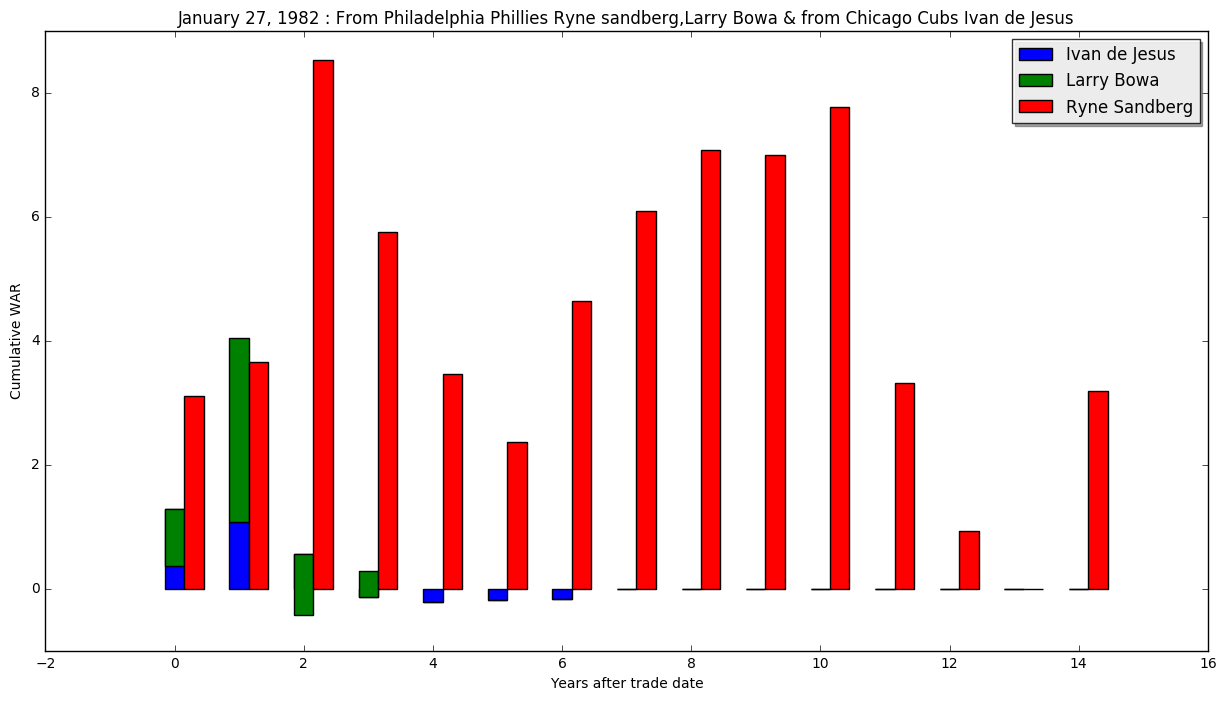

In [34]:
#Trade Analysis for a particulat trade
y = [1.28,1.08,0.55,-0.14,-0.22,-0.18,-0.17,0,0,0,0,0,0,0,0]
z = [-0.91,2.96,-0.97,0.43,0,0,0,0,0,0,0,0,0,0,0]
k = [3.11,3.66,8.52,5.75,3.46,2.36,4.63,6.09,7.07,7.00,7.76,3.32,0.93,0,3.19]
#x1 = ["1982","1983","1984","1985","1986","1987","1988","1989","1990","1991","1992","1993","1994","1995","1996"]
x1 = [1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996]
x = np.arange(len(y))

plt.figure(figsize=(15, 8))
plt.title("January 27, 1982 : From Philadelphia Phillies Ryne sandberg,Larry Bowa & from Chicago Cubs Ivan de Jesus")
plt.xlabel("Years after trade date")
plt.ylabel("Cumulative WAR")
#plt.xticks(x1)
ax = plt.subplot(111)
ax.bar(x, y,width=0.3,color='b',align='center')
ax.bar(x, z,width=0.3,color='g',align='center', bottom=y)
ax.bar(x+0.3, k,width=0.3,color='r',align='center')
ax.legend(loc="upper right",frameon = True,framealpha=0.8,shadow=True,
           labels=("Ivan de Jesus","Larry Bowa","Ryne Sandberg"))
plt.show()

In [35]:
#Calculates the absolute difference between two sides of a trade by summing the WAR values of each player on each side one
# year after the trade took place
def trade_value_mod(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    year = td['tranYear'].iloc[0]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        val = 0
        for index, row in td.iterrows():
            #val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction
                    continue
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(df_batstat['year_ID'] == row['tranYear'])]
                #instead need a df for the player after the trans year, and not just next, but all consecutive years
                for i in range(15):
                    player_df_year_next = player_df[(df_batstat['year_ID'] == (row['tranYear'] + i))]
                    if not player_df_year_next.empty:
                        # get the value of metric for each year after trade until 15 years else assume 0
                        val += float(player_df_year_next[metric].iloc[0]) - getAvgWarForAge(player_df_year_next['age'].iloc[0])
                    else:
                        ## figure out a way to find war for these players
                        val += 0
        player_vals.append(val)
    return (abs(player_vals[1]-player_vals[0]),tranID,year)

In [36]:
#Calculating the trade value difference for each transaction using metric WAR,WAA,PA,Salary & TA
trade_val_list_WAR_mod = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    trade_val_list_WAR_mod.append(trade_value_mod(x,'WAR'))

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [37]:
temp_df = pd.DataFrame(trade_val_list_WAR_mod, columns=["WAR_Diff","TranID","TranYear"])
years = temp_df['TranYear'].unique()
years = sorted(years)
means = []
medians = []
maxs = []
for i in years:
    yd = temp_df[(temp_df['TranYear'] == i)]
    means.append(yd["WAR_Diff"].mean())
    maxs.append(yd["WAR_Diff"].max())
    medians.append(yd["WAR_Diff"].median())

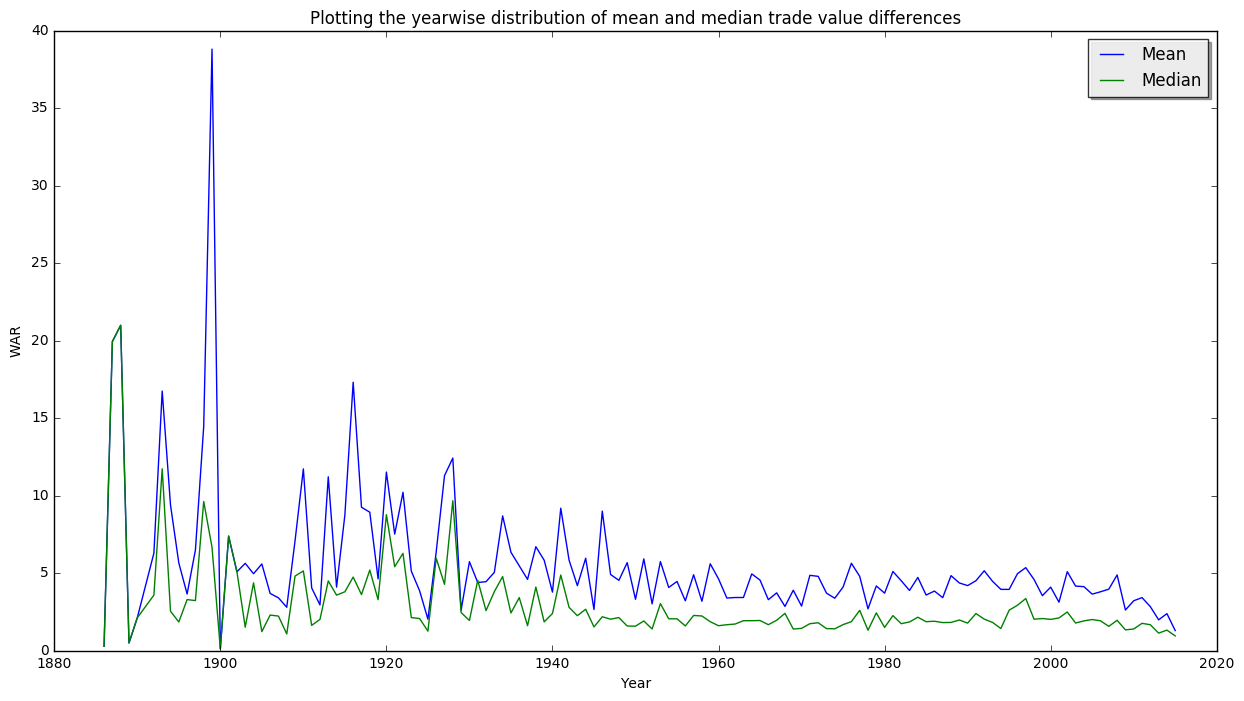

In [38]:
plt.figure(figsize=(15, 8))
plt.title("Plotting the yearwise distribution of mean and median trade value differences")
plt.xlabel("Year")
plt.ylabel("WAR")
plt.plot(years, means);
plt.plot(years, medians,color='g');
plt.legend(loc="upper right",frameon = True,framealpha=0.8,shadow=True,
           labels=("Mean","Median"))
#plt.plot(years, maxs,color='r');

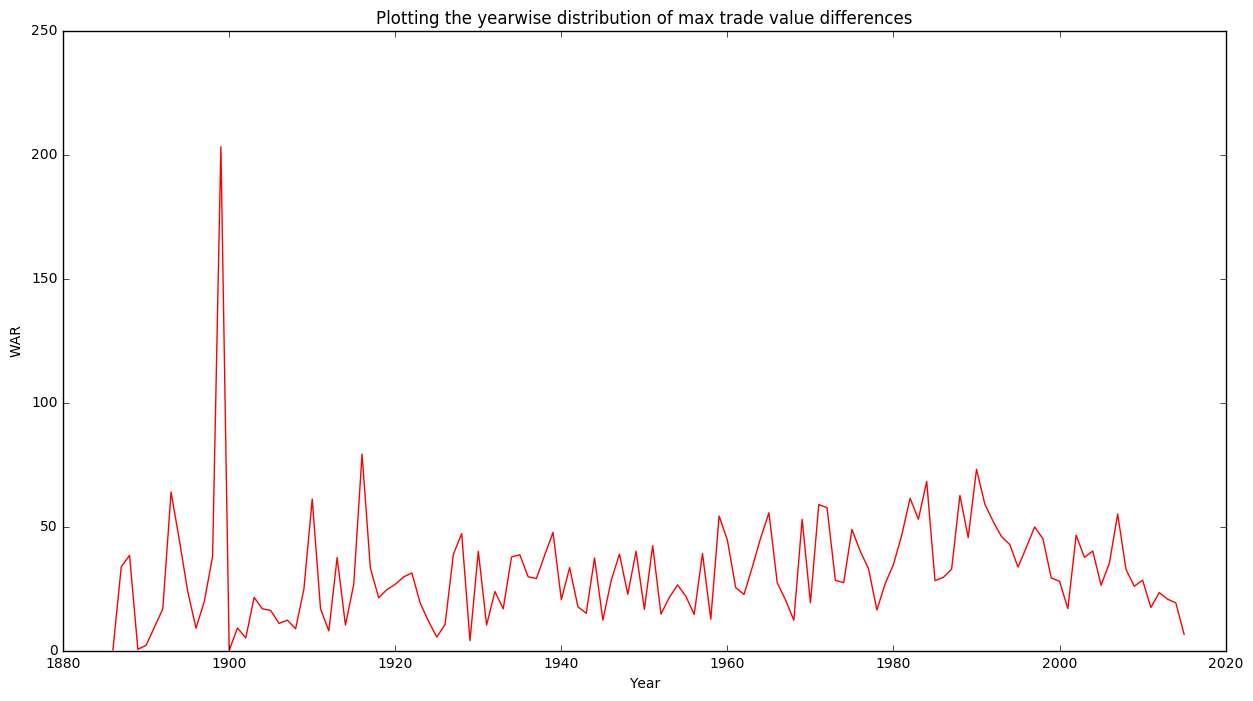

In [39]:
plt.figure(figsize=(15, 8))
plt.title("Plotting the yearwise distribution of max trade value differences")
plt.xlabel("Year")
plt.ylabel("WAR")
plt.plot(years, maxs,color='r');

In [40]:
#trade_val_list_WAR
#trade_val_list_WAR_old
val_list_1 = pd.DataFrame(trade_val_list_WAR, columns=["WAR_Diff","TranID"])
val_list_2 = pd.DataFrame(trade_val_list_WAR_old, columns=["WAR_Diff","TranID"])
sorted_val_list_1 = val_list_1.sort(["TranID"], ascending=[False])
sorted_val_list_2 = val_list_2.sort(["TranID"], ascending=[False])

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [41]:
sorted_val_list_1

WAR_Diff  TranID
5621  -0.173260   77618
5620  -1.174521   77616
5619   2.212915   77614
5618   1.367771   77606
5617   3.946345   77601
5616  -1.087277   77593
5615   3.327457   77582
5614  -0.740740   77576
5613  -1.134521   77573
5612   6.553458   77564
5611  -0.733589   77554
5610  -2.144288   77546
5609   0.959367   77544
5608   0.175479   77377
5607   0.851318   77256
5606   0.453240   76974
5605  -1.191842   76908
5604  -0.357277   76904
5603  -1.767746   76902
5602  -0.881075   76900
5601  -1.110740   76898
5600  -1.064486   76886
5599  -0.647949   76879
5598  -0.492482   76849
5597   0.376411   76838
5596   2.905537   76834
5595  -0.522392   76824
5594   0.388248   76791
5593   0.482723   76786
5592  -0.817277   76784
...         ...     ...
33    23.940097   48254
32    -1.980381   48253
31     1.838557   48252
30    -0.432424   48251
29     0.324137   48250
28     0.560842   48249
27     4.156664   48248
26     0.913836   48247
25    -0.556252   48246
24    -5.694716   48245
23   -44.449567   48244
22   -17.639805   48243
19     1.669070   48239
18    32.374841   48238
17     9.470341   48237
16   -13.974718   48236
15    63.858807   48235
14    19.486202   48234
13     2.647379   48233
12    16.709935   48232
11     1.261750   48231
10     1.614795   48230
9     -5.530564   48229
8      2.110565   48226
7      0.486176   48220
6      3.600039   48212
5     38.362381   48210
4     -6.102590   48205
3     33.766990   48204
2     -0.269864   48198

[5622 rows x 2 columns]

In [42]:
sorted_val_list_2

WAR_Diff  TranID
5621     -0.04   77618
5620      0.00   77616
5619      0.62   77614
5618     -0.39   77606
5617      0.91   77601
5616      0.03   77593
5615      2.08   77582
5614      0.31   77576
5613      0.02   77573
5612      1.70   77564
5611      0.04   77554
5610     -0.57   77546
5609      0.87   77544
5608      0.01   77377
5607      0.39   77256
5606     -0.10   76974
5605      0.08   76908
5604      0.64   76904
5603     -0.17   76902
5602     -0.34   76900
5601      0.18   76898
5600     -0.01   76886
5599      0.01   76879
5598      0.03   76849
5597      0.86   76838
5596      1.36   76834
5595      0.37   76824
5594     -0.32   76791
5593      0.60   76786
5592      0.03   76784
...        ...     ...
33        3.94   48254
32        0.64   48253
31        1.26   48252
30       -1.27   48251
29       -0.43   48250
28        0.14   48249
27        0.50   48248
26        0.83   48247
25        1.11   48246
24       -1.02   48245
23       -2.83   48244
22        0.56   48243
19        0.31   48239
18       -0.60   48238
17        0.43   48237
16       -3.93   48236
15        2.16   48235
14        1.87   48234
13        1.50   48233
12       -3.29   48232
11        0.45   48231
10       -0.67   48230
9        -3.91   48229
8         0.67   48226
7         0.82   48220
6        -0.30   48212
5        -0.16   48210
4        -2.83   48205
3        -1.05   48204
2        -1.67   48198

[5622 rows x 2 columns]

In [43]:
# 1. Scatter Plots
#Plotting a scatter plot between GDP Per Capita and Life Expectancy along with a best fit line
#plt.figure(figsize=(15, 8))
#plt.scatter(sorted_val_list_1["WAR_Diff"], sorted_val_list_2["WAR_Diff"])
#plt.plot(sorted_val_list_1["WAR_Diff"], np.poly1d(np.polyfit(sorted_val_list_1["WAR_Diff"], sorted_val_list_2["WAR_Diff"], 1))(sorted_val_list_1["WAR_Diff"]))
#plt.ylabel('Current Year', {'fontsize':14})
#plt.xlabel('15 year later', {'fontsize':14})
#plt.title('Current Year vs 15 Year Later', {'fontsize':18})
#description = "The plot shows the relation between WAR Diff after 15 years and the year of the trade"
#plt.annotate(description, xy=(0, -0.2), size=14, xycoords='axes fraction', color='blue')
#plt.show()

Mean Square Error: 7.65097667407


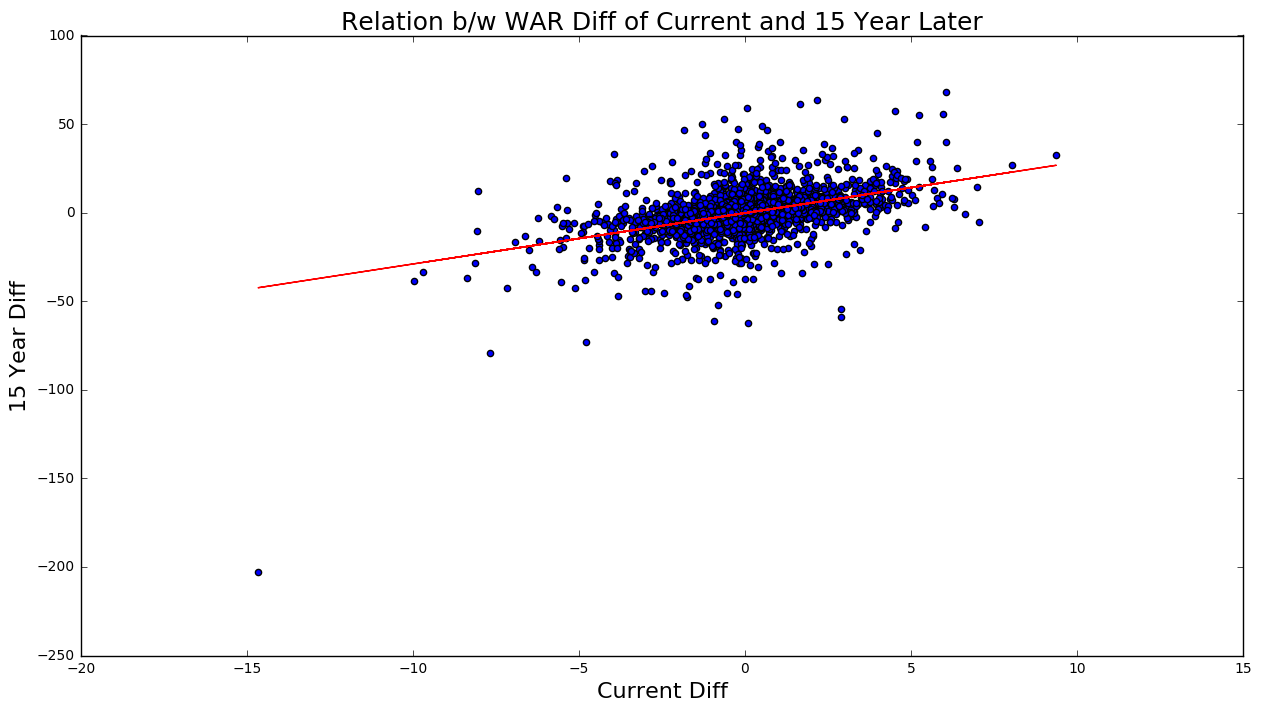

In [44]:
#Linear Regression Model
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

(a,b) = np.polyfit(sorted_val_list_2["WAR_Diff"], sorted_val_list_1["WAR_Diff"], deg=1)
err =  np.sqrt(mean_squared_error(np.polyval([a,b], sorted_val_list_2["WAR_Diff"]), sorted_val_list_1["WAR_Diff"]))
print "Mean Square Error:", err

plt.figure(figsize=(15, 8))
#description = """Explanation: The linear regression model with least mean square error has been the one with Life Expectancy. \nHere, the country most above the forecast is Monaco and this seems pretty correct. \nAs per Wikipedia: Monaco has the world's second highest GDP nominal per capita and the lowest poverty rate.\nThis can be attributed to its gambling industry,favorable tax policies making it a tax haven and large tourism industry.\n
#The country most below the forecast is: Solomon Islands, this can be be attributed to its underdeveloped state.\nIt's economy mainly depends on fisheries and timber exports with most of the high end goods and petroleum products \nbeing imported into the country. Only 60% of school age children have access to primary education, this reflects \nits poor economic state and hence the forecast makes sense."""
#plt.annotate(description, xy=(0, -0.45), size=15, xycoords='axes fraction',color='blue')
plt.xlabel('Current Diff', {'fontsize':16})
plt.ylabel('15 Year Diff', {'fontsize':16})
plt.title('Relation b/w WAR Diff of Current and 15 Year Later', {'fontsize':18})
plt.plot(sorted_val_list_2["WAR_Diff"], a * sorted_val_list_2["WAR_Diff"] + b, color='red')
plt.scatter(sorted_val_list_2["WAR_Diff"], sorted_val_list_1["WAR_Diff"])

In [45]:
#Correlation Coefficent
import scipy.stats as sct
value = sct.pearsonr(sorted_val_list_1["WAR_Diff"],sorted_val_list_2["WAR_Diff"])
#coeff_list.append((value[0], value[1], x, y))
print "Correlation Coefficient:",value[0]
print "Correlation p-Value:",value[1]

Correlation Coefficient: 0.448158969925
Correlation p-Value: 5.83780560133e-276


In [46]:
#Accuracy measurement
sorted_val_list_1_list = sorted_val_list_1.values.tolist()
sorted_val_list_2_list = sorted_val_list_2.values.tolist()
matches = 0
#Check if predictions are matching (just sign comparisons, this denotes which side got a better deal)
for i in range(len(sorted_val_list_1_list)):
    if((sorted_val_list_1_list[i][0] > 0 and sorted_val_list_2_list[i][0] > 0) or
      (sorted_val_list_1_list[i][0] < 0 and sorted_val_list_2_list[i][0] < 0)):
        matches += 1

accuracy = float(matches)/len(sorted_val_list_1_list)
print "Accuracy: ",accuracy

Accuracy:  0.583422269655


In [47]:
import re
#Taking 2016 CPI as current
curr_cpi = df_cpi[df_cpi['Year']==2016]['CPI'].iloc[0]

#Calculating the value of each cash tran as per CPI to 2016 value
#When incorrect values obeserved, making the new val as -1
new_cash_val = []
for index, row in df_tran.iterrows():
    if not((pd.isnull(row['cash'])) ):
        t1 = row['cash']
        t1 = re.sub('[$]', '', t1)
        old_cpi_df = df_cpi[df_cpi['Year']== row['tranYear']]['CPI']
        old_cpi = old_cpi_df.iloc[0]
        #print t1,old_cpi
        try:
            new_val = float((curr_cpi/old_cpi))*float(t1)
            #print new_val
            new_cash_val.append(new_val)
        except ValueError,e:
            print "error",e,"on row",row['cash']
            new_cash_val.append(-1)
    else:
        new_cash_val.append(-1)

#Finally adding the calculated values as a new column in df_tran without the $ sign
df_tran['cash_curr'] = new_cash_val
#df_tran['cash_curr']

error could not convert string to float:  on row 
error could not convert string to float:  on row 
error could not convert string to float:  on row 
error could not convert string to float:  on row 
error could not convert string to float:  on row 
error could not convert string to float:  on row 
error could not convert string to float:  on row 
error could not convert string to float:  on row 
error could not convert string to float:  on row 
error could not convert string to float:  on row 
error could not convert string to float:  on row 
error could not convert string to float:  on row 
error could not convert string to float:  on row 
error could not convert string to float:  on row 
error could not convert string to float:  on row 
error could not convert string to float:  on row 
error could not convert string to float:  on row 
error could not convert string to float:  on row 
error could not convert string to float:  on row 
error could not convert string to float:  on row 


In [48]:
df_tran

primary-date  time  approximate-indicator  secondary-date  \
32372          1968-12-10   NaN                    NaN             NaN   
32373          1967-08-17   NaN                    NaN             NaN   
32374          1967-11-22   NaN                    NaN             NaN   
50583          1964-01-01   NaN                    NaN             NaN   
50584          1964-01-01   NaN                    NaN             NaN   
58667 1886-12-01 00:00:00   NaN                    NaN             NaN   
58668 1886-12-01 00:00:00   NaN                    NaN             NaN   
58669 1886-12-01 00:00:00   NaN                    NaN             NaN   
58696 1887-04-21 00:00:00   NaN                    NaN             NaN   
58697 1887-04-21 00:00:00   NaN                    NaN             NaN   
58698 1887-04-21 00:00:00   NaN                    NaN             NaN   
58699 1887-10-20 00:00:00   NaN                    NaN             NaN   
58700 1887-10-20 00:00:00   NaN                    NaN             NaN   
58701 1887-10-20 00:00:00   NaN                    NaN             NaN   
58727 1888-05-01 00:00:00   NaN                    NaN             NaN   
58728 1888-05-01 00:00:00   NaN                    NaN             NaN   
58729 1888-05-01 00:00:00   NaN                    NaN             NaN   
58734 1888-06-16 00:00:00   NaN                    NaN             NaN   
58735 1888-06-16 00:00:00   NaN                    NaN             NaN   
58756 1889-03-29 00:00:00   NaN                    NaN             NaN   
58757 1889-03-29 00:00:00   NaN                    NaN             NaN   
58794 1890-08-22 00:00:00   NaN                    NaN             NaN   
58795 1890-08-22 00:00:00   NaN                    NaN             NaN   
58796 1890-08-22 00:00:00   NaN                    NaN             NaN   
58797 1890-08-22 00:00:00   NaN                    NaN             NaN   
58806 1892-04-05 00:00:00   NaN                    NaN             NaN   
58807 1892-04-05 00:00:00   NaN                    NaN             NaN   
58808 1892-04-05 00:00:00   NaN                    NaN             NaN   
58809 1892-06-14 00:00:00   NaN                    NaN             NaN   
58810 1892-06-14 00:00:00   NaN                    NaN             NaN   
...                   ...   ...                    ...             ...   
85073          2015-11-12   NaN                    NaN             NaN   
85074          2015-11-12   NaN                    NaN             NaN   
85075          2015-11-12   NaN                    NaN             NaN   
85076          2015-11-12   NaN                    NaN             NaN   
85077          2015-11-12   NaN                    NaN             NaN   
85085          2015-11-13   NaN                    NaN             NaN   
85086          2015-11-13   NaN                    NaN             NaN   
85087          2015-11-13   NaN                    NaN             NaN   
85088          2015-11-13   NaN                    NaN             NaN   
85089          2015-11-13   NaN                    NaN             NaN   
85091          2015-11-14   NaN                    NaN             NaN   
85092          2015-11-14   NaN                    NaN             NaN   
85097          2015-11-16   NaN                    NaN             NaN   
85098          2015-11-16   NaN                    NaN             NaN   
85099          2015-11-16   NaN                    NaN             NaN   
85100          2015-11-16   NaN                    NaN             NaN   
85110          2015-11-18   NaN                    NaN             NaN   
85111          2015-11-18   NaN                    NaN             NaN   
85112          2015-11-18   NaN                    NaN             NaN   
85119          2015-11-19   NaN                    NaN             NaN   
85120          2015-11-19   NaN                    NaN             NaN   
85124          2015-11-20   NaN                    NaN             NaN   
85125          20

In [49]:
df_salaries = pd.read_csv('../dataset/Salaries.csv')

In [ ]:
#df_salaries

In [ ]:
#adjusting salaries based  on inflation
curr_cpi = df_cpi[df_cpi['Year']==2016]['CPI'].iloc[0]
print curr_cpi
#Calculating the value of each sallaries as per CPI to 2016 value
salary_per_yr = []
war=[]
for index, row in df_salaries.iterrows():
    if not((pd.isnull(row['salary'])) ):
        t1 = row['salary']
        old_cpi_df = df_cpi[df_cpi['Year']== row['yearID']]['CPI']
        player_war = df_batstat[(df_batstat['year_ID']==row['yearID']) & (df_batstat['player_ID']==row['playerID'])]['WAR']
        if (player_war.empty):
            print 'values is null'
            player_war = df_pitchstat[(df_pitchstat['year_ID']==row['yearID']) & (df_pitchstat['player_ID']==row['playerID'])]['WAR']
        if (player_war.empty):
            war.append(0)
        else:
            war.append(player_war.values[0])
        old_cpi = old_cpi_df.iloc[0]
        print t1,old_cpi
        try:
            new_val = float((curr_cpi/old_cpi))*float(t1)
            print 'printing',new_val
            salary_per_yr.append(new_val)
        except ValueError,e:
            print "error",e,"on row",row['cash']
            salary_per_yr.append(0)
    else:
        war.append(0)
        salary_per_yr.append(0)
   
#Finally adding the calculated values as a new column in df_tran without the $ sign
#df_tran['cash_curr'] = new_cash_val
#df_tran['cash_curr']

719.7
870000 323.2
printing 1937311.26238
550000 323.2
printing 1224737.00495
545000 323.2
printing 1213603.03218
633333 323.2
printing 1410302.47556
625000 323.2
printing 1391746.59653
800000 323.2
printing 1781435.64356
150000 323.2
printing 334019.183168
483333 323.2
printing 1076283.29239
772000 323.2
printing 1719085.39604
250000 323.2
printing 556698.638614
1500000 323.2
printing 3340191.83168
455000 323.2
printing 1013191.52228
407500 323.2
printing 907418.780941
275000 323.2
printing 612368.502475
775000 323.2
printing 1725765.7797
1625000 323.2
printing 3618541.15099
616667 323.2
printing 1373190.71751
450000 323.2
printing 1002057.5495
120000 323.2
printing 267215.346535
750000 323.2
printing 1670095.91584
1354167 323.2
printing 3015451.70142
800000 323.2
printing 1781435.64356
625000 323.2
printing 1391746.59653
480000 323.2
printing 1068861.38614
437500 323.2
printing 974222.617574
512500 323.2
printing 1141232.20916
375000 323.2
printing 835047.957921
641667 323.2
printing

In [ ]:
len(war)
#avg = np.nansum(war) / float(len(war))
#print avg


In [ ]:
df_salaries['Salary_curr'] = salary_per_yr
df_salaries['WAR'] = war
df_salaries

In [ ]:
#df_pitchstat

In [ ]:
# calculating average salary and war
average_salary = np.nansum(salary_per_yr) / float(len(salary_per_yr))
average_war = np.nansum(war) / float(len(war))
print average_salary, average_war

In [ ]:
#0.64061427175 war is equivalent to 2514082.95989 
#so 1 war will be equivlent to
print average_salary/average_war